In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GRU, Bidirectional, concatenate, Flatten
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Define the Grey Wolf Optimizer
class GreyWolfOptimizer:
    def __init__(self, obj_function, n_agents, max_iter, dim, lb, ub):
        self.obj_function = obj_function
        self.n_agents = n_agents
        self.max_iter = max_iter
        self.dim = dim
        self.lb = np.array(lb)
        self.ub = np.array(ub)

    def optimize(self):
        alpha_pos = np.zeros(self.dim)
        alpha_score = float("inf")

        beta_pos = np.zeros(self.dim)
        beta_score = float("inf")

        delta_pos = np.zeros(self.dim)
        delta_score = float("inf")

        positions = np.random.uniform(self.lb, self.ub, (self.n_agents, self.dim))

        fitness_curve = []  # To track the fitness score across iterations

        for t in range(self.max_iter):
            for i in range(self.n_agents):
                fitness = self.obj_function(positions[i, :])

                if fitness < alpha_score:
                    alpha_score = fitness
                    alpha_pos = positions[i, :].copy()

                elif fitness < beta_score:
                    beta_score = fitness
                    beta_pos = positions[i, :].copy()

                elif fitness < delta_score:
                    delta_score = fitness
                    delta_pos = positions[i, :].copy()

            a = 2 - t * (2 / self.max_iter)

            for i in range(self.n_agents):
                for j in range(self.dim):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A1, C1 = 2 * a * r1 - a, 2 * r2
                    D_alpha = abs(C1 * alpha_pos[j] - positions[i, j])
                    X1 = alpha_pos[j] - A1 * D_alpha

                    r1, r2 = np.random.rand(), np.random.rand()
                    A2, C2 = 2 * a * r1 - a, 2 * r2
                    D_beta = abs(C2 * beta_pos[j] - positions[i, j])
                    X2 = beta_pos[j] - A2 * D_beta

                    r1, r2 = np.random.rand(), np.random.rand()
                    A3, C3 = 2 * a * r1 - a, 2 * r2
                    D_delta = abs(C3 * delta_pos[j] - positions[i, j])
                    X3 = delta_pos[j] - A3 * D_delta

                    positions[i, j] = (X1 + X2 + X3) / 3

                positions[i, :] = np.clip(positions[i, :], self.lb, self.ub)

            fitness_curve.append(alpha_score)

        return alpha_pos, alpha_score, fitness_curve



In [ ]:
# Load and preprocess data
df = pd.read_csv('KDD.txt', sep=",", header=None)
df = df.dropna(how="any")
df[41] = df[41].map({"teardrop.": 5, "satan.": 4, "portsweep.": 3, "smurf.": 2, "neptune.": 1, "normal.": 0})

X = df.iloc[:, 4:41].values
y = df.iloc[:, 41].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=121, stratify=y)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Before optimization: Print the initial parameters (using default values)
initial_units = 64  # Example initial value before optimization
initial_dropout = 0.2  # Example initial value before optimization

print(f"Initial Model Parameters (Before Optimization):")
print(f"GRU Units: {initial_units}")
print(f"Dropout Rate: {initial_dropout}")
print("\n")

# Define the objective function for GWO tuning
def obj_function(params):
    units, dropout = params
    units = int(units)

    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer = Dense(64, activation='relu')(input_layer)
    reshaped_layer = tf.keras.layers.Reshape((1, 64))(dense_layer)
    bi_gru_layer = Bidirectional(GRU(units, return_sequences=True))(reshaped_layer)
    bi_gru_layer = Dropout(dropout)(bi_gru_layer)
    flat_layer = Flatten()(bi_gru_layer)
    output_layer = Dense(6, activation='softmax')(flat_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=0, batch_size=32)

    val_accuracy = history.history['val_accuracy'][-1]
    return -val_accuracy


In [ ]:
# Set GWO parameters and run optimization
n_agents = 10
max_iter = 20
dim = 2
lb = [16, 0.1]
ub = [128, 0.5]

gwo = GreyWolfOptimizer(obj_function, n_agents, max_iter, dim, lb, ub)
best_params, best_score, fitness_curve_before = gwo.optimize()

best_units = int(best_params[0])
best_dropout = best_params[1]

Tuned Model Parameters (After GWO Optimization):
GRU Units: 115
Dropout Rate: 0.471952571119288




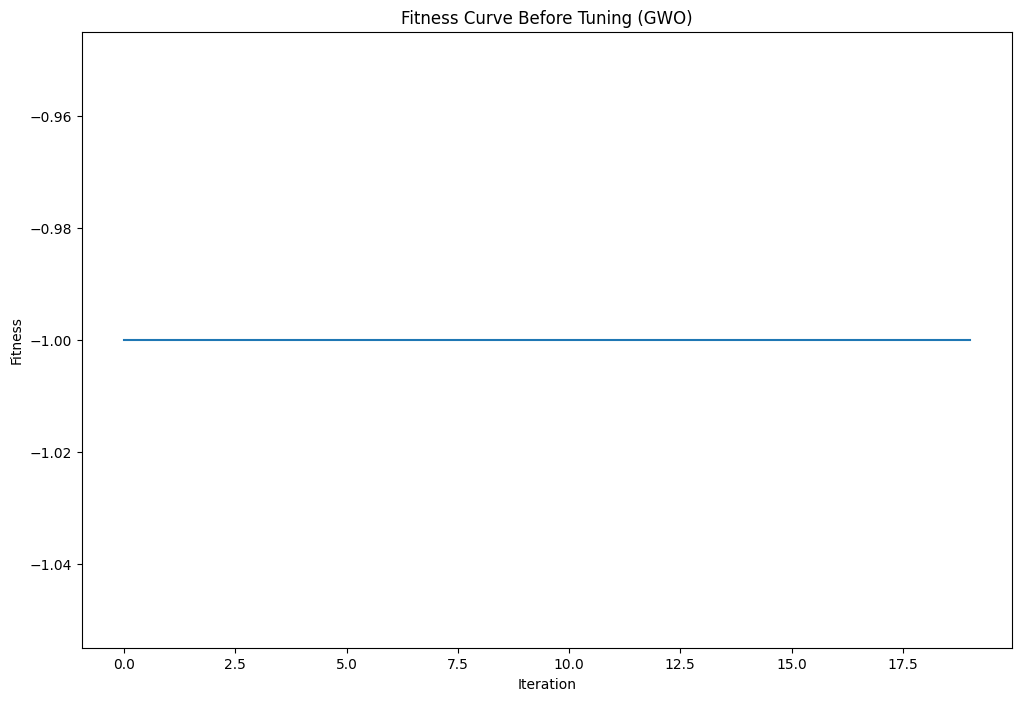

In [ ]:
# After optimization: Print the tuned parameters
print(f"Tuned Model Parameters (After GWO Optimization):")
print(f"GRU Units: {best_units}")
print(f"Dropout Rate: {best_dropout}")
print("\n")
plt.figure(figsize=(12, 8))
plt.plot(fitness_curve_before)
plt.title('Fitness Curve Before Tuning (GWO)')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

In [ ]:
# Build and train the final model using the tuned parameters
input_layer = Input(shape=(X_train.shape[1],))
dense_layer = Dense(64, activation='relu')(input_layer)
reshaped_layer = tf.keras.layers.Reshape((1, 64))(dense_layer)
bi_gru_layer = Bidirectional(GRU(best_units, return_sequences=True))(reshaped_layer)
bi_gru_layer = Dropout(best_dropout)(bi_gru_layer)
flat_layer = Flatten()(bi_gru_layer)
output_layer = Dense(6, activation='softmax')(flat_layer)

final_model = Model(inputs=input_layer, outputs=output_layer)
final_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
history = final_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5793 - loss: 1.1882 - val_accuracy: 1.0000 - val_loss: 0.0514
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9934 - loss: 0.0899 - val_accuracy: 1.0000 - val_loss: 0.0199
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9990 - loss: 0.0443 - val_accuracy: 1.0000 - val_loss: 0.0119
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0326 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9954 - loss: 0.0262 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0181 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 1.0000 - val

In [ ]:
# Evaluate the final model
y_pred = final_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
kappa = cohen_kappa_score(y_true, y_pred)

print(f"Final Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Final Model Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Cohen's Kappa: 1.0


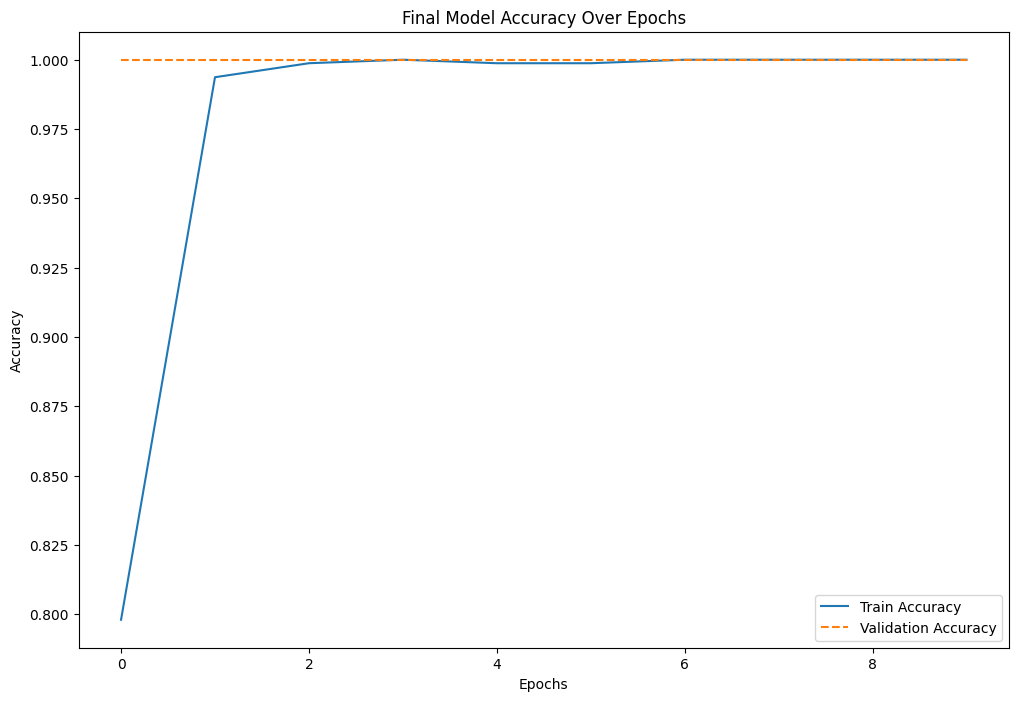

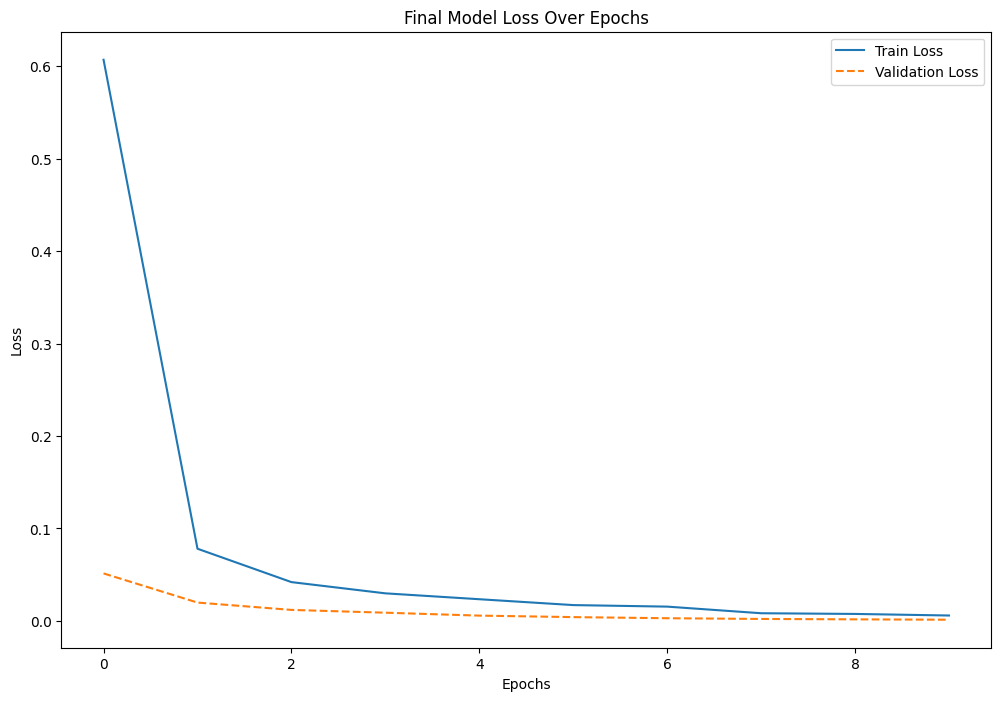

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Final Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Final Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

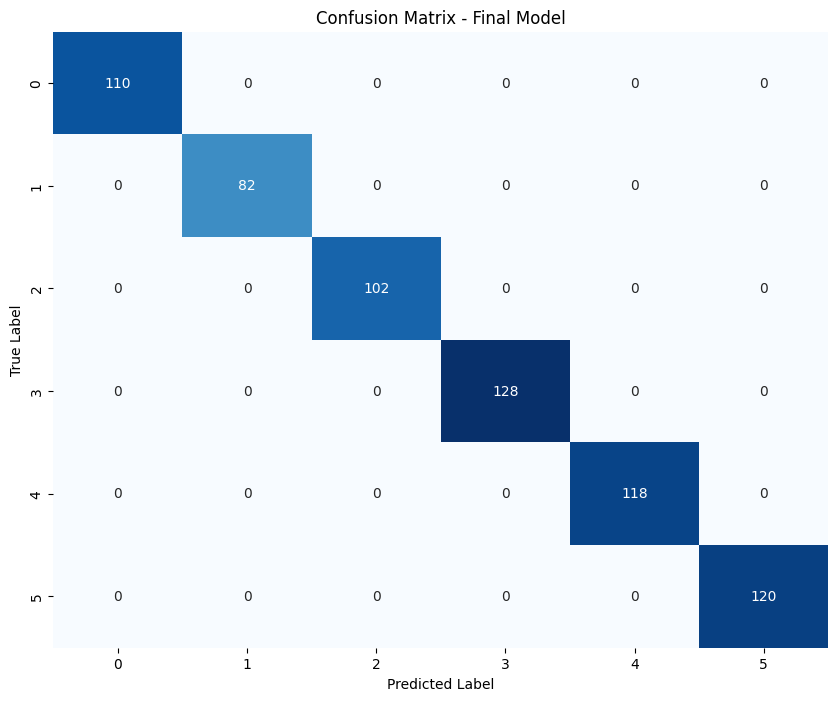

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


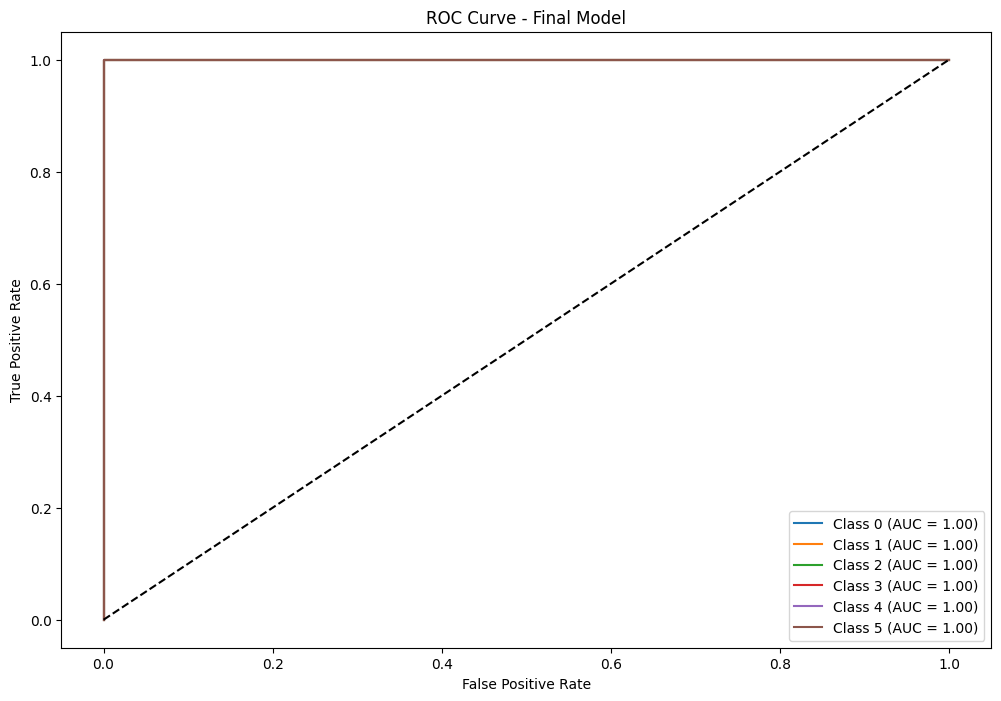

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Final Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curves and AUC Scores
plt.figure(figsize=(12, 8))
y_pred_proba = final_model.predict(X_test)
for i in range(6):  # Assuming 6 classes
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Final Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()